## 先验的选取策略

在之前的实验中，对于某个变量的先验我们总是直接给出。接下啦，我们将解决贝叶斯推断的最后一个问题。那就是先验的选取策略。本实验，将对先验的选取进行详细的阐述。然后，引入了多臂老虎机的实例，利用贝叶斯推断求得最佳决策。最后，介绍了一种可以衡量模型与最佳策略的差距的方法：总遗憾。

- 主观先验和客观先验
- Beta 分布
- 贝叶斯多臂老虎机
- 共轭先验
- 实验轮盘赌法

Gamma 分布的随机变量是一个正实数变量，记作  $X \sim \text{Gamma}(\alpha, \beta)$。它其实是指数随机变量的扩展。该分布的密度函数如下：

$$ f(x \mid \alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)} $$

其中  $\Gamma(\alpha)$ 是 Gamma 函数，$\alpha$ 和 $\beta$ 是函数中的常量。

我们可以直接利用 `Scipy.stats` 函数库调用该分布。接下来让我们对该函数进行可视化，观察不同 $\alpha$ 和 $\beta$ 下的函数变化：

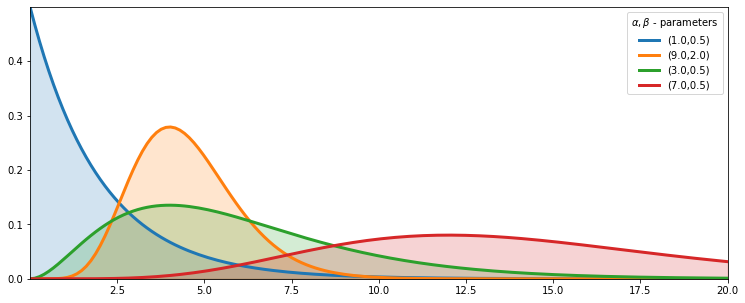

In [1]:
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
%matplotlib inline

figsize(12.5, 5)
gamma = stats.gamma

# 设置里多组函数的常数量
parameters = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]
x = np.linspace(0.001, 20, 150)
for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale=1./beta)
    lines = plt.plot(x, y, label="(%.1f,%.1f)" % (alpha, beta), lw=3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)

plt.legend(title=r"$\alpha, \beta$ - parameters")

如上图，展示了不同 $\alpha$ 和 $\beta$ 下的 Gamma 分布。其实，我们在学习一个分布函数时，无需记住该函数的具体表达式（当然，如果你对公式很敏感的话，也可以将它们记下啦），我们只需记住这些分函数的图像即可。 

#### 威沙特分布
威沙特分布和我们之前学的所有分布函数都不一样。我们之前学的都是分布都是产生一个标量的随机变量，而这次我们学的分布函数会产生一个随机矩阵。具体的说，威沙特分布其实就是所有半正定矩阵的分布。

Beta 分布是贝叶斯统计学中最常用的分布函数之一。随机变量 $X$ 的密度函数如下：  

$$f_X(x | \; \alpha, \beta ) = \frac{ x^{(\alpha - 1)}(1-x)^{ (\beta - 1) } }{B(\alpha, \beta) }$$

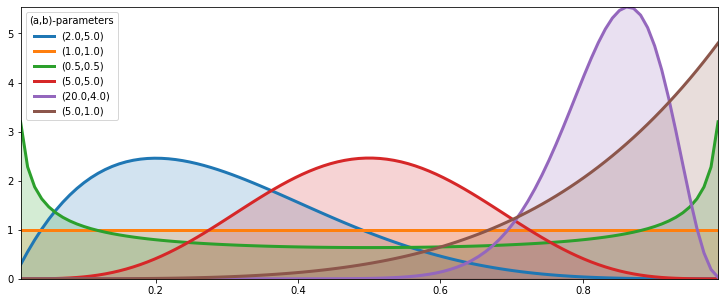

In [2]:
figsize(12.5, 5)
# 设置了多组参数
params = [(2, 5), (1, 1), (0.5, 0.5), (5, 5), (20, 4), (5, 1)]

x = np.linspace(0.01, .99, 100)
beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines = plt.plot(x, y, label="(%.1f,%.1f)" % (a, b), lw=3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
plt.ylim(0)
plt.legend(loc='upper left', title="(a,b)-parameters")

仔细观察上图，我们可以发现其实由扁平分布的存在，即参数为（1,1）情况下，Beta 分布即为均匀分布。因此，我们可以说 Beta 分布是均匀分布的一般形式，均匀分布是 Beta 分布的特殊形式。

不仅是均匀分布，Beta 分布还和二项分布存在着微妙的关系。假设模型中有一个参数 p，然后设置它的先验它的先验概率为Beta分布。假设我们利用二项分布 $X \sim \text{Binomial}(N, p)$ 去随机生成观测样本，并把这些样本放入模型中进行学习。那么，当我们得到 p 的后验分布时，会惊讶的发现后验分布也是 Beta 分布。换句话说，一个 Beta 先验分布连同有二项式分布生成的观察数据会形成一个 Beta 的后验分布，该分布为，$p | X \sim \text{Beta}( \alpha + X, \beta + N -X )$，其中 N 表示样本数。

### 例子：贝叶斯多臂老虎机

假设现在你面对 10 台老虎机（即为多臂的意思），每台老虎机会以某种概率发奖金。假设每台老虎机的奖金份额相同，只是概率不同。当然，我们不知道这些概率，并且每次我们只能选择一个老虎机，那么我们应该制定一个怎样的策略去赢取更多的奖金呢？

其实很免明显的事情，就是我们只要知道哪一台老虎机发放奖金的概率最大，那我们就总是用这台老虎机，这样我们就能拿到更多的奖金了。因此，其实，我们的任务可以简述为“最快速度找到发放奖金概率最高的老虎机”。

- 互联网的广告展示：公司有一系列广告可以想潜在客户展示，但是公司不知道应该采用何种展示策略，来最大限度提高销售额度。
- 生态学：动物冬眠是不摄取能量，在此期间每一种行为都会消耗不同的能力，那么应该进行哪些行为，才能让它挺过冬天呢？
- 金融学：在随时间变化的回报量中，哪些股票期权能够带来最高的回报？

In [3]:
rand = np.random.rand


class Bandits(object):
    """
     该类表示 N 个老虎机

    parameters:
        p_array: a (n 

    methods:
        pull( i ): 返回 1,0.
            1：代表此次发了钱 0：代表此次没发钱
    """

    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)

    def pull(self, i):
        # i is which arm to pull
        return np.random.rand() < self.p[i]

    def __len__(self):
        return len(self.p)


# 测试
Bandits([1])

In [4]:
class BayesianStrategy(object):
    """
    实现多臂老虎机的学习算法 
    parameters:
        bandits: 上面的老虎机类

    methods:
        sample_bandits(n): 对老虎机进行训练和取样

    attributes:
        N: 累计的样本数
        choices:大小：(N,)，记录历史结果 
        bb_score:大小： (N,) ，记录历史分数
    """

    def __init__(self, bandits):

        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    def sample_bandits(self, n=1):

        bb_score = np.zeros(n)
        choices = np.zeros(n)

        for k in range(n):
            # sample from the bandits's priors, and select the largest sample
            choice = np.argmax(np.random.beta(
                1 + self.wins, 1 + self.trials - self.wins))

            # sample the chosen bandit
            result = self.bandits.pull(choice)

            # update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice

        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

In [5]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001, .999, 200)


def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    # plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha,
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                       colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +
                  "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

最后，让我们初始化三台老虎机和它的发钱概率，并传入老虎机类中（模拟现实的老虎机）。然后利用老虎机的解决方案，寻找这三台老虎机的发钱概率分布，如下：

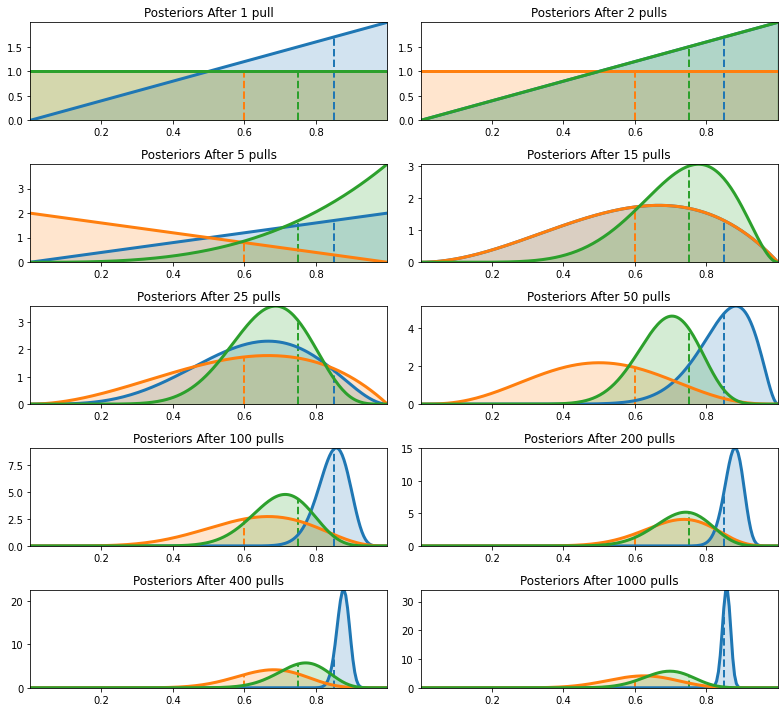

In [6]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    # plt.legend()
    plt.autoscale(tight=True)
plt.tight_layout()

我们需要一个指标来衡量算法来衡量我们的算法的优越性。因此，这里我们引入**总遗憾**的概念。即 T 轮最优策略（即**理想情况下**，每一局，都在那台最好的老虎机上）和上述策略之间的收益差距，定义为：

\begin{align}
R_T & = \sum_{i=1}^{T} \left( w_{opt} - w_{B(i)} \right)\\\\
& = Tw^* - \sum_{i=1}^{T} \;  w_{B(i)} 
\end{align}

其中 $ w_{B(i)} $ 是所选老虎机在第 $i$ 轮出奖的概率，$w_{opt}$ 为最好的那台老虎机的出奖概率。

In [7]:
# 返回前N 天的遗憾总和
# 第一个参数为每台老虎机的真实发钱率，第二个表示实验中，每次选择的是第几胎老虎机


def regret(probabilities, choices):
    w_opt = probabilities.max()
    # 返回前 1 的数据总和，前 2的数据总和....前 N 的数据总和，
    return (w_opt - probabilities[choices.astype(int)]).cumsum()


bayesian_strat.sample_bandits(10000)
regrets = regret(hidden_prob, bayesian_strat.choices)
regrets[3]  # 表示前三次实验的遗憾总和

0.29999999999999993

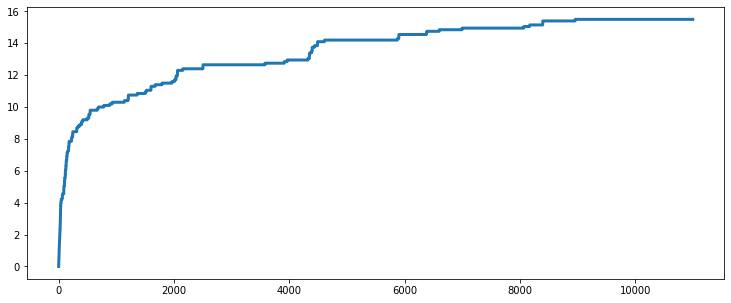

In [8]:
figsize(12.5, 5)
plt.plot(regrets, lw=3)

### 样本数对先验的印象

在实验 1 中，我们说过这样一句话，当我们拥有足够多的观测数据时，参数的先验就显得那么重要了。这其实是符合现实的，因为我们的先验也是基于以前的信息，而足够多的新信息完全可以代替以前的信息对模型的价值。并且足够多的数据对先验的修正是有帮助的。因此，即使我们的先验明显错误，但是数据的自我修正性质也可以为我们呈现出较为合理的后验。

我们可以从数学上，看到这一点。假设，给定数据集 $X$，对参数 $\theta$ 的后验分布可以写作：

$$p(\theta | {\textbf X}) \propto \underbrace{p({\textbf X} | \theta)}_{{\textrm 似然}}  \cdot  \overbrace{ p(\theta) }^{ {\textrm 先验} }  $$

$$ \log( p(\theta | {\textbf X})  ) = c + L(\theta;{\textbf X}) + \log(p(\theta)) $$

对数似然函数 （$L(\theta;{\textbf X}) = \log \left( p({\textbf X}|\theta) \right)$） 会随之样本量而变化，因为该函数需要数据。而先验的密度函数不会，因为它不需要真实数据。因此，当样本量增加时， $L(\theta;{\textbf X})$ 的绝对值会变大，但是 $\log(p(\theta))$ 会保持不变 (当 $\theta$值固定时)。因此，随着样本量的增加，函数 $L(\theta;{\textbf X}) + \log(p(\theta))$ 更多的是受 $L(\theta;{\textbf X})$ 的影响，而非 $ \log(p(\theta))$。 

In [9]:
# 扁平先验
beta1_params = np.array([1., 1.])
# 朝着0偏移的beta先验
beta2_params = np.array([2, 10])
beta = stats.beta

# 定义真实数据的产生，服从二项分布
p = 0.6
data = stats.bernoulli.rvs(p, size=500)
data

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,

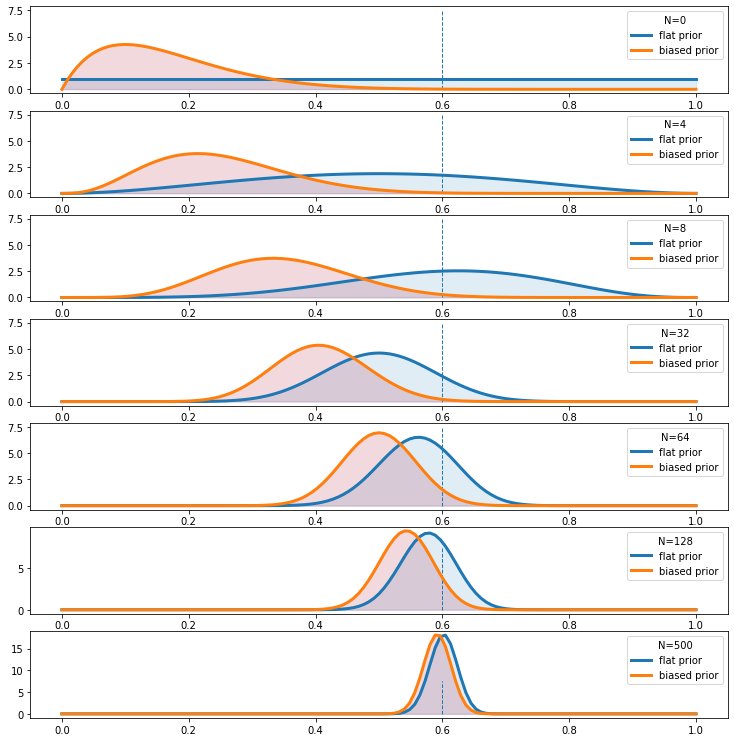

In [10]:
figsize(12.5, 15)
# 定义很多表
x = np.linspace(0.00, 1, 125)
plt.figure()
# 观察具有0,4,8, 32,64, 128, 500个样本下的两个模型的后验分布
for i, N in enumerate([0, 4, 8, 32, 64, 128, 500]):
    s = data[:N].sum()
    plt.subplot(8, 1, i+1)
    params1 = beta1_params + np.array([s, N-s])
    params2 = beta2_params + np.array([s, N-s])
    y1, y2 = beta.pdf(x, *params1), beta.pdf(x, *params2)
    plt.plot(x, y1, label=r"flat prior", lw=3)
    plt.plot(x, y2, label="biased prior", lw=3)
    plt.fill_between(x, 0, y1, color="#348ABD", alpha=0.15)
    plt.fill_between(x, 0, y2, color="#A60628", alpha=0.15)
    plt.legend(title="N=%d" % N)
    plt.vlines(p, 0.0, 7.5, linestyles="--", linewidth=1)

从上图中，我们可以清楚的看到后验分布在随着样本量的逐渐增多的情况下，忘记他的先验，数据越多，先验忘得越多。因此，在数据量足够的情况下，贝叶斯推断和频率论推断是收敛在一起的。

至此，我们的贝叶斯推断课程全部完成。学习完本实验后，我们可以了解到，先验的选取没有固定套路，但是可以根据实际情况的后验状况来调整我们设定的先验分布。最后，让我们再来总结一下贝叶斯推断的思路过程。首先确定需要求的参数是什么，并为这些参数设定相应的先验概率。其次，确定我们可以观察到的数据是什么，找到数据变量和我们需要求的参数的关系，并且建立模型。最后将真实数据传入模型（即将真实数据固定到模型中的相应变量上），进行训练。最后，得到了所求参数的后验分布样本。